> None

In [1]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

In [2]:
from matplotlib import cm
from pygsp import graphs, filters, plotting, utils
import plotly.graph_objects as go

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
class Conf_matrx:
    def __init__(self,original,compare,tab):
        self.original = original
        self.compare = compare
        self.tab = tab
    def conf(self,name):
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        for i in range(self.conf_matrix.shape[0]):
            for j in range(self.conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        print('Accuracy: %.3f' % self.acc)
        print('Precision: %.3f' % self.pre)
        print('Recall: %.3f' % self.rec)
        print('F1 Score: %.3f' % self.f1)
        
        self.tab = self.tab.append(pd.DataFrame({"Accuracy":[self.acc],"Precision":[self.pre],"Recall":[self.rec],"F1":[self.f1]},index = [name]))


In [4]:
%load_ext rpy2.ipython

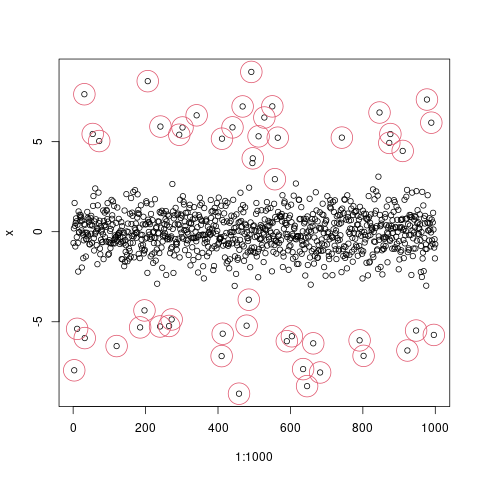

In [51]:
%%R
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-7,-5), runif(25,5,7), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
index_of_trueoutlier_bool = signal!=0

x=signal+epsilon
plot(1:1000,x)
points(index_of_trueoutlier,x[index_of_trueoutlier],col=2,cex=4)

%%R
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-7,-2.5), runif(25,2.5,7), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
index_of_trueoutlier_bool = signal!=0

x=signal+epsilon
plot(1:1000,x)
points(index_of_trueoutlier,x[index_of_trueoutlier],col=2,cex=4)

In [52]:
%R -o x
%R -o index_of_trueoutlier
%R -o index_of_trueoutlier_bool
%R -o signal

In [53]:
index_of_trueoutlier_bool=np.array(index_of_trueoutlier_bool,dtype=np.bool8)

In [54]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [55]:
xhat = np.array(ebayesthresh(FloatVector(x)))

## Linear(1)

In [56]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [57]:
df1=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [58]:
w=np.zeros((1000,1000))

In [59]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [60]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5,ref=20,ymin=-5,ymax=20,cuts=0,cutf=995): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        self.differ=(np.abs(self.y-self.yhat)-np.min(np.abs(self.y-self.yhat)))/(np.max(np.abs(self.y-self.yhat))-np.min(np.abs(self.y-self.yhat))) #color 표현은 위핸 표준화
        self.df = self.df.assign(differ = self.differ)
        
        fig,ax = plt.subplots(figsize=(10,10))
        ax.scatter(self.x,self.y,color='gray',s=50,alpha=0.7)
        ax.scatter(self.x[index_of_trueoutlier_bool],self.y[index_of_trueoutlier_bool],color='red',s=50)
        ax.plot(self.x[cuts:cutf],self.yhat[cuts:cutf], '--k',lw=3)
        ax.scatter(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],color='red',s=550,facecolors='none', edgecolors='r')
        fig.tight_layout()
        fig.savefig('fig1.eps',format='eps')

In [61]:
_simul = SIMUL(df1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


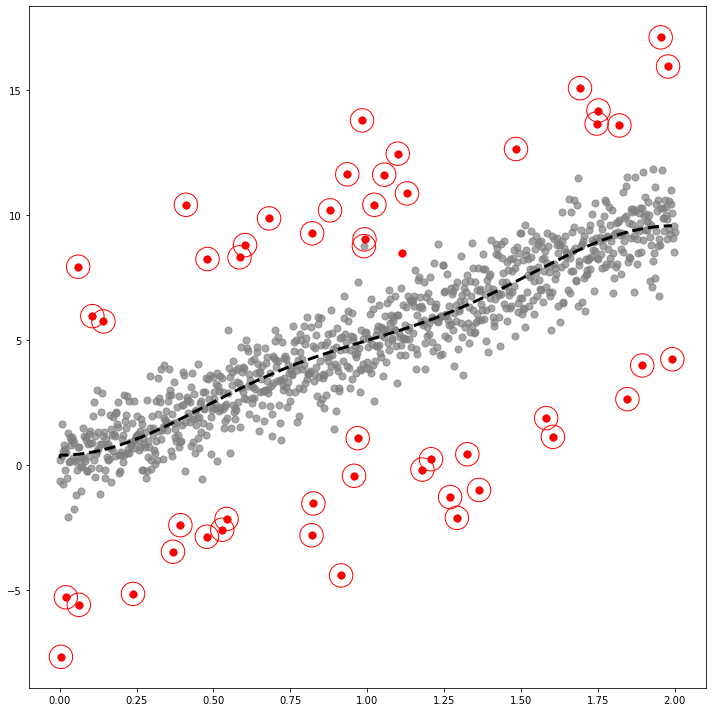

In [62]:
_simul.fit(sd=20,ref=9.8)

In [65]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [66]:
outlier_simul_one = list(map(lambda x: -1 if x > 9.8 else 1,outlier_simul_one))

In [67]:
tab_linear = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1"])

In [68]:
_signal = list(map(lambda x: -1 if x!=0 else 1,signal))


In [69]:
_conf = Conf_matrx(_signal,outlier_simul_one,tab_linear)

In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

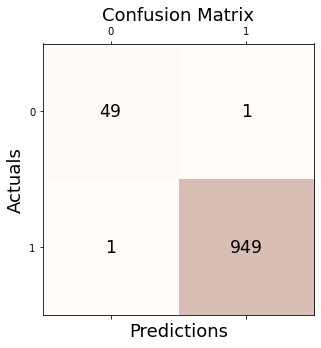

Accuracy: 0.998
Precision: 0.999
Recall: 0.999
F1 Score: 0.999


In [72]:
_conf.conf("GODE")

---

---

---

---

---

---

---

---

In [ ]:
## Linear(2)

In [ ]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [ ]:
df2=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [ ]:
_simul2 = SIMUL(df2)

In [ ]:
_simul2.fit(sd=20,ref=20,ymin=-10,ymax=15)

In [ ]:
## COS

In [ ]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [ ]:
df4=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [ ]:
_simul4 = SIMUL(df4)

In [ ]:
_simul4.fit(sd=20,ref=20,ymin=-10,ymax=15)

In [ ]:
## SIN

In [75]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [76]:
df5=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [ ]:
_simul5 = SIMUL(df5)

In [ ]:
_simul5.fit(ref=15,ymin=-10,ymax=15,cuts=5)

In [ ]:
## 1D manifold

In [ ]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + x

In [ ]:
df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f, 'f1' : f1})

In [ ]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.f1 = df.f1.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=60): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.dif=(np.abs(self.f-self.fhat)-np.min(np.abs(self.f-self.fhat)))/(np.max(np.abs(self.f-self.fhat))-np.min(np.abs(self.f-self.fhat)))
        self.df = self.df.assign(dif = self.dif)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05
#         fig = plt.figure(figsize=(10,10))
        # ax = fig.add_subplot(1,1,1, projection='3d')
        #
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,15),subplot_kw={"projection":"3d"})
        ax1.grid(False)
        ax1.scatter3D(self.x,self.y,self.f,zdir='z',s=50,marker='.',color='gray')
        ax1.scatter3D(self.x[index_of_trueoutlier_bool],self.y[index_of_trueoutlier_bool],self.f[index_of_trueoutlier_bool],zdir='z',s=50,marker='.',color='red')
        ax1.scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['f'],edgecolors='red',zdir='z',s=50,facecolors='none')
        ax1.plot3D(self.x,self.y,self.f1,'--k',lw=3)
        ax2.view_init(elev=30., azim=60)
        
        ax2.grid(False)
        ax2.scatter3D(self.x,self.y,self.f,zdir='z',s=50,marker='.',color='gray')
        ax2.scatter3D(self.x[index_of_trueoutlier_bool],self.y[index_of_trueoutlier_bool],self.f[index_of_trueoutlier_bool],zdir='z',s=50,marker='.',color='red') 
        ax2.scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['f'],edgecolors='red',zdir='z',s=50,facecolors='none')
        ax2.plot3D(self.x,self.y,self.f1,'--k',lw=3)
        ax2.view_init(elev=30., azim=40)
        
        ax3.grid(False)
        ax3.scatter3D(self.x,self.y,self.f,zdir='z',s=50,marker='.',color='gray')
        ax3.scatter3D(self.x[index_of_trueoutlier_bool],self.y[index_of_trueoutlier_bool],self.f[index_of_trueoutlier_bool],zdir='z',s=50,marker='.',color='red') 
        ax3.scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['f'],edgecolors='red',zdir='z',s=50,facecolors='none')
        ax3.plot3D(self.x,self.y,self.f1,'--k',lw=3)
        ax3.view_init(elev=30., azim=10)
        
        fig.savefig('fig2.eps',format='eps')

In [ ]:
_simul3d = SIMUL(df)

In [ ]:
_simul3d.get_distance()

In [ ]:
_simul3d.get_weightmatrix(theta=(_simul3d.D[_simul3d.D>0].mean()),kappa=2500) 

In [ ]:
(_simul3d.D[_simul3d.D>0].mean())

In [ ]:
%%capture --no-display
_simul3d.fit(sd=15,ref=20)

In [ ]:
## Bunny

In [ ]:
G = graphs.Bunny()
n = G.N

In [ ]:
g = filters.Heat(G, tau=75) # 꼬리부분의 빨간신호를 퍼지게하는 정도

In [ ]:
normal = np.random.randn(n)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif

In [ ]:
index_of_trueoutlier_bool = (unif!=0)

In [ ]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

In [ ]:
W = G.W.toarray()
x = G.coords[:,0]
y = G.coords[:,1]
z = -G.coords[:,2]

In [ ]:
df = pd.DataFrame({'x' : x, 'y' : y, 'z' : z, 'f' : f, 'noise' : noise})

In [ ]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=2.5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05
        
        fig = plt.figure(figsize=(30,12),dpi=400)
        ax1 = fig.add_subplot(251, projection='3d')
        ax1.grid(False)
        ax1.scatter3D(self.x,self.y,self.z,c='gray',zdir='z',alpha=0.5,marker='.')
        ax1.view_init(elev=60., azim=-90)

        ax2= fig.add_subplot(252, projection='3d')
        ax2.grid(False)
        ax2.scatter3D(self.x,self.y,self.z,c=self.f,cmap='hsv',zdir='z',marker='.',alpha=0.5,vmin=-12,vmax=10)
        ax2.view_init(elev=60., azim=-90)

        ax3= fig.add_subplot(253, projection='3d')
        ax3.grid(False)
        ax3.scatter3D(self.x,self.y,self.z,c=self.fnoise,cmap='hsv',zdir='z',marker='.',alpha=0.5,vmin=-12,vmax=10)
        ax3.view_init(elev=60., azim=-90)
        
        ax4= fig.add_subplot(254, projection='3d')
        ax4.grid(False)
        ax4.scatter3D(self.x,self.y,self.z,c=self.fnoise,cmap='hsv',zdir='z',marker='.',vmin=-12,vmax=10,s=1)
        ax4.scatter3D(self.x[index_of_trueoutlier_bool],self.y[index_of_trueoutlier_bool],self.z[index_of_trueoutlier_bool],c=self.fnoise[index_of_trueoutlier_bool],cmap='hsv',zdir='z',marker='.',s=50)
        ax4.view_init(elev=60., azim=-90)

        ax5= fig.add_subplot(255, projection='3d')
        ax5.grid(False)
        ax5.scatter3D(self.x,self.y,self.z,c=self.fnoise,cmap='hsv',zdir='z',marker='.',vmin=-12,vmax=10,s=1)
        ax5.scatter3D(self.x[index_of_trueoutlier_bool],self.y[index_of_trueoutlier_bool],self.z[index_of_trueoutlier_bool],c=self.fnoise[index_of_trueoutlier_bool],cmap='hsv',zdir='z',marker='.',s=50)
        ax5.scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['z'],zdir='z',s=550,marker='.',edgecolors='red',facecolors='none')
        ax5.view_init(elev=60., azim=-90)
        
        ax6 = fig.add_subplot(256, projection='3d')
        ax6.grid(False)
        ax6.scatter3D(self.x,self.y,self.z,c='gray',zdir='z',alpha=0.5,marker='.')
        ax6.view_init(elev=-60., azim=-90)

        ax7= fig.add_subplot(257, projection='3d')
        ax7.grid(False)
        ax7.scatter3D(self.x,self.y,self.z,c=self.f,cmap='hsv',zdir='z',marker='.',alpha=0.5,vmin=-12,vmax=10)
        ax7.view_init(elev=-60., azim=-90)

        ax8= fig.add_subplot(258, projection='3d')
        ax8.grid(False)
        ax8.scatter3D(self.x,self.y,self.z,c=self.fnoise,cmap='hsv',zdir='z',marker='.',alpha=0.5,vmin=-12,vmax=10)
        ax8.view_init(elev=-60., azim=-90)
        
        ax9= fig.add_subplot(259, projection='3d')
        ax9.grid(False)
        ax9.scatter3D(self.x,self.y,self.z,c=self.fnoise,cmap='hsv',zdir='z',marker='.',vmin=-12,vmax=10,s=1)
        ax9.scatter3D(self.x[index_of_trueoutlier_bool],self.y[index_of_trueoutlier_bool],self.z[index_of_trueoutlier_bool],c=self.fnoise[index_of_trueoutlier_bool],cmap='hsv',zdir='z',marker='.',s=50)
        ax9.view_init(elev=-60., azim=-90)

        ax10= fig.add_subplot(2,5,10, projection='3d')
        ax10.grid(False)
        ax10.scatter3D(self.x,self.y,self.z,c=self.fnoise,cmap='hsv',zdir='z',marker='.',vmin=-12,vmax=10,s=1)
        ax10.scatter3D(self.x[index_of_trueoutlier_bool],self.y[index_of_trueoutlier_bool],self.z[index_of_trueoutlier_bool],c=self.fnoise[index_of_trueoutlier_bool],cmap='hsv',zdir='z',marker='.',s=50)
        ax10.scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['z'],zdir='z',s=550,marker='.',edgecolors='red',facecolors='none')
        ax10.view_init(elev=-60., azim=-90)        
        fig.savefig('fig_bunny.eps',format='eps')

In [ ]:
_simul = SIMUL(df)

In [ ]:
max(_simul.f),max(_simul.fnoise)

In [ ]:
min(_simul.f),min(_simul.fnoise)

In [ ]:
%%capture --no-display
_simul.fit(sd=20,ref=10)

In [ ]:
## Earthquake

In [ ]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

In [ ]:
df_global= pd.concat([pd.read_csv('00_05.csv'),pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv'),pd.read_csv('15_20.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

In [ ]:
df_global = df_global.assign(Year=list(map(lambda x: x.split('-')[0], df_global.time))).iloc[:,1:]

In [ ]:
df_global.Year = df_global.Year.astype(np.float64)

In [ ]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')

In [ ]:
class MooYaHo2(MooYaHo): # ebayesthresh 기능추가
    def fit2(self,ref=0.5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2)))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        self.con = np.where(self.df.Residual>0.7,1,0)

In [ ]:
class eachlocation(MooYaHo2):
    def haiti(self,MagThresh=7,ResThresh=1,adjzoom=5,adjmarkersize = 40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=18.4430, lon=-72.5710), 
                        zoom= adjzoom,
                        height=900,
                        opacity = 0.8,
                        mapbox_style="stamen-terrain",
                        range_color=[-3,3])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.4
                    )
                ))
        return fig 
    def lquique(self,MagThresh=7,ResThresh=1,adjzoom=5, adjmarkersize= 40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=-32.6953, lon=-71.4416), 
                        zoom=adjzoom,
                        height=900,
                        opacity = 0.8,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.8
                    )
                ))
        return fig 
    def sichuan(self,MagThresh=7,ResThresh=1,adjzoom=5,adjmarkersize=40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=30.3080, lon=102.8880), 
                        zoom=adjzoom,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.8
                    )
                ))
        return fig 

In [ ]:
each_location=eachlocation(df_global.query("2010 <= Year < 2015"))

In [ ]:
`-` get distance 

In [ ]:
each_location.get_distance()

In [ ]:
each_location.D[each_location.D>0].mean()

In [ ]:
plt.hist(each_location.D[each_location.D>0])

In [ ]:
`-` weight matrix

In [ ]:
each_location.get_weightmatrix(theta=(8810.865423093777),kappa=2500) 

In [ ]:
`-` fit

In [ ]:
each_location.fit2()

In [ ]:
each_location.haiti(MagThresh=6.9,ResThresh=0.5,adjzoom=5,adjmarkersize=40)
fig = each_location.haiti(MagThresh=6.9,ResThresh=0.5,adjzoom=5,adjmarkersize=40)
fig.write_image('fig_haiti.png',scale=3)

In [ ]:
each_location.lquique(MagThresh=6.4,ResThresh=0.4,adjzoom=5,adjmarkersize=40)
# fig = each_location.lquique(MagThresh=6.4,ResThresh=0.4,adjzoom=5,adjmarkersize=20)
# fig.write_image('fig_lquique.svg',scale=3)

In [ ]:
each_location.sichuan(MagThresh=6.5,ResThresh=0.4,adjzoom=5,adjmarkersize=40)
# fig = each_location.sichuan(MagThresh=6.5,ResThresh=0.4,adjzoom=5,adjmarkersize=20)
# fig.write_image('fig_sichuan.svg',scale=3)